**Notes on Labels and Naming**


- **NFE = SE (Sporadic Early-Onset POAG)**
- **NFL = SL (Sporadic Late-Onset POAG)**

The code keeps using the original tags `NFE` and `NFL` for compatibility, but throughout this notebook they correspond to **SE** and **SL** respectively.


In [ ]:
import pandas as pd
import numpy as np
# 讀檔
csv_file = '3054SNPs.csv'
data_np = pd.read_csv(csv_file).values[:-5,:][:,:-1]
print(data_np.shape)
tag_np = data_np[:,-1].copy()
tag_list = np.unique(tag_np)
print(tag_list)
for tag in tag_list:
    print(tag, ':', np.sum(tag_np==tag))

id_list = list(data_np[:,0])
print(len(id_list))
print(id_list)

test_id_list = list(data_np[np.logical_or(tag_np=='NFE',tag_np=='GC'),0])
print(len(test_id_list))
print(test_id_list)

(177, 3057)
['FC' 'FE' 'FL' 'GC' 'NFE' 'NFL' 'S']
FC : 22
FE : 24
FL : 22
GC : 36
NFE : 36
NFL : 27
S : 10
177
['il67', 'il69', 'il70', '30', '26', '54', '66', '76', '83', '35', '127', 'il71', 'il68', '61', '32', '62', '25', '63', '53', '68', '69', '77', '75', '82', '93', '87', '85', '125', '126', 'N7', 'N8', 'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'R3', 'R4', '24', '27', '28', '29', '40', '42', '19', '20', '21', '121', '122', '123', '90', '94', '84', '64', '65', '97', '38', '132', '135', '124', '95', '99', '45', '50', '55', '91', '100', '105', '111', '44', '48', '80', '81', '86', 'WE11', 'WE12', 'WE13', 'WE14', 'WE15', 'WE16', '136', '137', '138', '139', '147', '148', '150', '151', '152', '155', '153', '154', 'GC20', 'GC5', 'GC16', 'GC13', 'GC2', 'GC21', 'GC14', 'GC22', 'GC3', 'GC17', 'GC6', 'GC7', 'GC8', 'GC23', 'GC1', 'GC24', 'GC18', 'GC25', 'GC26', 'GC27', 'GC28', 'GC29', 'GC30', 'GC31', 'GC15', 'GC32', 'GC33', 'GC9', 'GC19', 'GC4', 'GC34', 'GC10', 'GC35', 'GC11', 'GC36', 'GC12', 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import copy

th = 0.5
total_iter = 500
best_nF_records = []
acc_records = []
recall_records = []
acc_records_ = []
recall_records_ = []
all_F_rank = [0]*(data_np.shape[1]-3)
case_records = np.zeros((177,5)) 
test_records = np.zeros((72,5))

for iter in range(total_iter):
    print(f'Trail {iter+1}:')
    train_pos = data_np[np.logical_or(tag_np=='FE',tag_np=='FL'),:]
    data_FC = data_np[tag_np=='FC',:]
    data_GC = data_np[tag_np=='GC',:]
    N_GC = data_GC.shape[0]
    idx_order = np.array(list(range(N_GC)))
    np.random.shuffle(idx_order)
    train_neg = np.vstack((data_FC, data_GC[idx_order[:14],:]))
    val_neg = data_GC[idx_order[14:25],:]
    test_neg = data_GC[idx_order[25:],:]
    data_NFE = data_np[tag_np=='NFE',:]
    N_NFE = data_NFE.shape[0]
    idx_order = np.array(list(range(N_NFE)))
    np.random.shuffle(idx_order)
    val_pos = data_NFE[idx_order[:18],:]
    test_pos = data_NFE[idx_order[18:],:]
    # train, val, test
    train = np.vstack((train_pos, train_neg))
    train_id = train[:,0]
    val = np.vstack((val_pos, val_neg))
    val_id = val[:,0]
    test = np.vstack((test_pos, test_neg))
    test_id = test[:,0]
    X1 = train[:,1:-2].astype(np.float32)  #  features (SNP)
    y1 = train[:,-2].astype(np.int32)  #  label
    X2 = val[:,1:-2].astype(np.float32)
    y2 = val[:,-2].astype(np.int32)
    X3 = test[:,1:-2].astype(np.float32)
    y3 = test[:,-2].astype(np.int32)
    # extra_test
    NFL_data = data_np[tag_np=='NFL',:]
    NFL_id = NFL_data[:,0]
    X4 = NFL_data[:,1:-2].astype(np.float32)
    y4 = NFL_data[:,-2].astype(np.int32)
    # Suspected
    S_data = data_np[tag_np=='S',:]
    S_id = S_data[:,0]
    X5 = S_data[:,1:-2].astype(np.float32)
    y5 = S_data[:,-2].astype(np.int32)

    # Feature Ranking on Val
    N, nF = X2.shape
    Feature_Rank_Records = [0]*nF

    for i in range(200):
        RF = RandomForestClassifier(n_estimators=200)
        RF.fit(X2, y2)

        F_importances = RF.feature_importances_
        F_rank = np.argsort(F_importances)[::-1]  # descending
        for idx, j in enumerate(F_rank):
            Feature_Rank_Records[j] += idx

    F_rank = np.argsort(Feature_Rank_Records)
    print(F_rank[:10])
    for idx, k in enumerate(F_rank):
        all_F_rank[k] += idx

    # best model on Val running inference on Test
    best_acc = 0
    best_val_model = None
    best_nF = 0
    for i in range(10,201):  
        # Feature selection
        selection = F_rank[:i]
        X = X1[:,selection]
        y = y1
        # Training
        RF = RandomForestClassifier(n_estimators=200)
        RF.fit(X, y)
        # Validation
        X_ = X2[:,selection]
        y_ = y2
        pred = RF.predict_proba(X_)
        N = X_.shape[0]
        cm = np.zeros((2,2), dtype=np.int32)
        T = th  # threshold for proba
        for j in range(N):
            p_id = 0
            if(pred[j,1]>=T):
                p_id = 1
            cm[y_[j],p_id] += 1
        acc = cm.trace()/cm.sum()
        recall = cm[1,1]/cm[1,:].sum() 
        if(acc>=best_acc):
            best_acc = acc
            best_val_model = copy.deepcopy(RF)
            best_nF = i

    # Training set
    X_ = X1[:,F_rank[:best_nF]]
    y_ = y1
    pred = best_val_model.predict_proba(X_)
    N = X_.shape[0]
    cm = np.zeros((2,2), dtype=np.int32)
    T = th  # threshold for proba
    for j in range(N):
        id_ = train_id[j]
        idx_ = id_list.index(id_)
        case_records[idx_,0] += 1
        case_records[idx_,1] += pred[j,1]
        case_records[idx_,2] += (pred[j,1])**2
        p_id = 0
        if(pred[j,1]>=T):
            p_id = 1
        cm[y_[j],p_id] += 1
    acc = cm.trace()/cm.sum()
    recall = cm[1,1]/cm[1,:].sum() 
    print(f'Train: #features={best_nF}', f'acc={acc}', f'recall={recall}')
    print('cm =', cm)

    # Best on validation
    X_ = X2[:,F_rank[:best_nF]]
    y_ = y2
    pred = best_val_model.predict_proba(X_)
    N = X_.shape[0]
    cm = np.zeros((2,2), dtype=np.int32)
    T = th  # threshold for proba
    for j in range(N):
        id_ = val_id[j]
        idx_ = id_list.index(id_)
        case_records[idx_,0] += 1
        case_records[idx_,1] += pred[j,1]
        case_records[idx_,2] += (pred[j,1])**2
        p_id = 0
        if(pred[j,1]>=T):
            p_id = 1
        cm[y_[j],p_id] += 1
    acc = cm.trace()/cm.sum()
    recall = cm[1,1]/cm[1,:].sum() 
    print(f'Val: #features={best_nF}', f'acc={acc}', f'recall={recall}')
    print('cm =', cm)

    # Testing
    X_ = X3[:,F_rank[:best_nF]]
    y_ = y3
    pred = best_val_model.predict_proba(X_)
    N = X_.shape[0]
    cm = np.zeros((2,2), dtype=np.int32)
    T = th  # threshold for proba
    for j in range(N):
        id_ = test_id[j]
        idx_ = id_list.index(id_)
        case_records[idx_,0] += 1
        case_records[idx_,1] += pred[j,1]
        case_records[idx_,2] += (pred[j,1])**2

        idx_ = test_id_list.index(id_)
        test_records[idx_,0] += 1
        test_records[idx_,1] += pred[j,1]
        test_records[idx_,2] += (pred[j,1])**2

        p_id = 0
        if(pred[j,1]>=T):
            p_id = 1
        cm[y_[j],p_id] += 1
    acc = cm.trace()/cm.sum()
    recall = cm[1,1]/cm[1,:].sum() 
    print(f'Test: #features={best_nF}', f'acc={acc}', f'recall={recall}')
    print('cm =', cm)
    best_nF_records.append(best_nF)
    acc_records.append(acc)
    recall_records.append(recall)

    #額外Testing
    X_ = X4[:,F_rank[:best_nF]]
    y_ = y4
    pred = best_val_model.predict_proba(X_)
    N = X_.shape[0]
    # cm = np.zeros((2,2), dtype=np.int32)
    T = th  # threshold for proba
    for j in range(N):
        id_ = NFL_id[j]
        idx_ = id_list.index(id_)
        case_records[idx_,0] += 1
        case_records[idx_,1] += pred[j,1]
        case_records[idx_,2] += (pred[j,1])**2
        p_id = 0
        if(pred[j,1]>=T):
            p_id = 1
        cm[y_[j],p_id] += 1
    acc = cm.trace()/cm.sum()
    recall = cm[1,1]/cm[1,:].sum() 
    print(f'Extra_Test: #features={best_nF}', f'acc={acc}', f'recall={recall}')
    print('cm =', cm)
    print('')
    acc_records_.append(acc)
    recall_records_.append(recall)

    #Suspected
    X_ = X5[:,F_rank[:best_nF]]
    y_ = y5
    pred = best_val_model.predict_proba(X_)
    N = X_.shape[0]
    for j in range(N):
        id_ = S_id[j]
        idx_ = id_list.index(id_)
        case_records[idx_,0] += 1
        case_records[idx_,1] += pred[j,1]
        case_records[idx_,2] += (pred[j,1])**2


Trail 1:
[1410  552  755  551  927  855 1370 2909  511   69]
Train: #features=161 acc=1.0 recall=1.0
cm = [[36  0]
 [ 0 46]]
Val: #features=161 acc=1.0 recall=1.0
cm = [[11  0]
 [ 0 18]]
Test: #features=161 acc=0.9655172413793104 recall=0.9444444444444444
cm = [[11  0]
 [ 1 17]]
Extra_Test: #features=161 acc=0.6071428571428571 recall=0.5111111111111111
cm = [[11  0]
 [22 23]]

Trail 2:
[ 300  552 1410  551 2909  855  927 1370   68 1190]
Train: #features=174 acc=1.0 recall=1.0
cm = [[36  0]
 [ 0 46]]
Val: #features=174 acc=1.0 recall=1.0
cm = [[11  0]
 [ 0 18]]
Test: #features=174 acc=0.9655172413793104 recall=0.9444444444444444
cm = [[11  0]
 [ 1 17]]
Extra_Test: #features=174 acc=0.6071428571428571 recall=0.5111111111111111
cm = [[11  0]
 [22 23]]

Trail 3:
[2909  552  927 1370  855 1410  285 2410  551 1190]
Train: #features=183 acc=1.0 recall=1.0
cm = [[36  0]
 [ 0 46]]
Val: #features=183 acc=1.0 recall=1.0
cm = [[11  0]
 [ 0 18]]
Test: #features=183 acc=1.0 recall=1.0
cm = [[11  0]


In [4]:
print(all_F_rank[552])
print(all_F_rank[1410])
print(all_F_rank[551])
print(all_F_rank[855])
print(all_F_rank[927])

1265
1656
2087
2389
2492


In [ ]:


F_rank = np.argsort(all_F_rank)
print(F_rank[:20])
np.savetxt('Feature_Rank_0826.csv', F_rank, fmt='%d', delimiter=',')

for k in range(177):
    case_records[k,3] = case_records[k,1]/case_records[k,0]
    EX2 = case_records[k,2]/case_records[k,0]
    case_records[k,4] = (EX2-(case_records[k,3])**2)**0.5
np.savetxt('all_samples_records_0826.csv', case_records, fmt='%1.3f', delimiter=',')

for k in range(72):
    test_records[k,3] = test_records[k,1]/test_records[k,0]
    EX2 = test_records[k,2]/test_records[k,0]
    test_records[k,4] = (EX2-(test_records[k,3])**2)**0.5
np.savetxt('test_records_0826.csv', test_records, fmt='%1.3f', delimiter=',')

performance = np.vstack((acc_records,recall_records,best_nF_records))
np.savetxt('performance_records_0826.csv', performance, fmt='%1.3f', delimiter=',')

performance_ = np.vstack((acc_records_,recall_records_))
np.savetxt('performance_records_withNFL_0826.csv', performance_, fmt='%1.3f', delimiter=',')

[ 552 1410  551  855  927 2909 1370   68 1190  977 1009  300 1219 1245
  804  500  499   69  947  923]


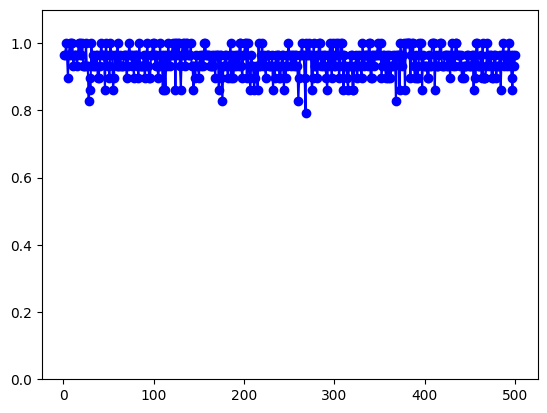

In [6]:
import matplotlib.pyplot as plt

plt.plot(list(range(1,total_iter+1)), acc_records, marker='o', color='b')
plt.ylim(0, 1.1)
plt.show()

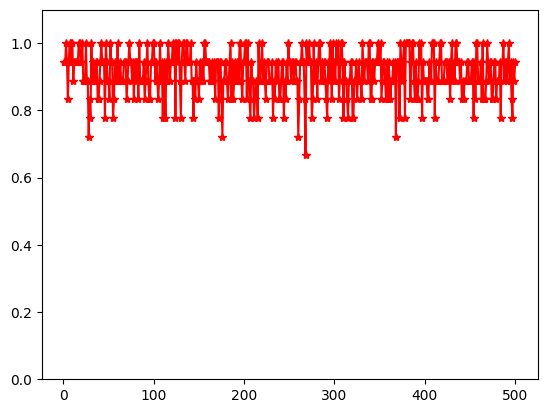

In [7]:
import matplotlib.pyplot as plt

plt.plot(list(range(1,total_iter+1)), recall_records, marker='*', color='r')
plt.ylim(0, 1.1)
plt.show()

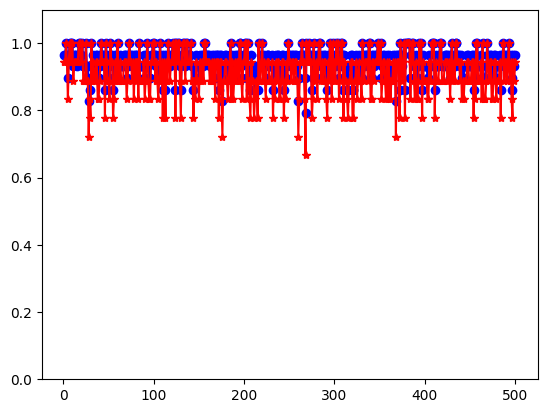

In [8]:
import matplotlib.pyplot as plt

plt.plot(list(range(1,total_iter+1)), acc_records, marker='o', color='b')
plt.plot(list(range(1,total_iter+1)), recall_records, marker='*', color='r')
plt.ylim(0, 1.1)
plt.show()

**accuracy record of "testing + extended dataset"**

In [9]:
print(np.sum(np.array(acc_records_)==1))
print(np.sum(np.array(acc_records_)>0.95))

0
0


**accuracy /recall of "testing + extended dataset"**

In [10]:
print(sum(acc_records_)/len(acc_records_))
print(sum(recall_records_)/len(recall_records_))
print(sum(best_nF_records)/len(best_nF_records))

0.5747142857142865
0.47080000000000094
182.456


**accuracy record of "testing set"**

In [11]:
print(np.sum(np.array(acc_records)==1))
print(np.sum(np.array(acc_records)>0.95))

83
261


**accuracy /recall of "testing set"**

In [12]:
print(sum(acc_records)/len(acc_records))
print(sum(recall_records)/len(recall_records))
print(sum(best_nF_records)/len(best_nF_records))

0.9455862068965483
0.9124444444444493
182.456
